In [0]:
import pandas as pd
import numpy as np
import os
import json
import re
import os
import datetime
from itertools import permutations 
from matplotlib import pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Initial feature engineering: 
 
<!-- Sometimes the data need to be processed, mapped, or adjusted.  Signals may need a Fourier transform or wavelet transform.  People's age or marital status  might be extrapolated from a title (Miss, Master, vs Mr. and Mrs).  Measurements given in degrees might need to be transformed to sine and cosine instead. Distance between points, or driving time, etc may need to be calculated.   -->
 
* ## Add new feature columns corresponding to appropriate functions of the original data.
    * ### Add to Friends Table:
        * **Friendship strength:** Normalized weighted sum of calls and video calls
        * **Similarity:** Weighted average of Native Country, Native Language, English Proficiency, Common Followed/Streamers with heavier weight on English Proficiency.
        * **Friends in common:** Number of common friends two people have in common.
    * ### Add to Users Table:
        * **Total Number of Friends:** Number of friends from the friends table
        * **Summarized User Bio:** As binary, has or doesn't have, (0,1). (Added in cleaning phase)
        * **Last Online:** Indicator of the last time they used the app. Last Day, Last Week, Last Month
        * **Activity measure:** Average of; Last Online, Bio, Friends Count, Number of followed Streamers
 
* ## Justify your choices. 
    * ### Friends Table
        * **Strength:**  The strength of a community is measured, in part, as a sum of individual friendships with their corresponding strengths. The main source of friend interaction is seen in communication through video and audio calls. Since more interaction is given in a video chat, we assume this is the best indicator of a friendship in comparison to a voice call. Thus we weigh video more than audio and sum them. After they are summed, we feed them into a quasi-sigmoid function to get a friendship strength value bounded by 0 and 1. We believe that many calls is only slightly better than a handful calls in predicting friendship due to the possible confounding variable user free time. This behavior is reflected in our sigmoid function.
        * **Similarity:** We make the assumption that friends tend to spend time on the app with people that are similar to them in characteristics such as culture and others that could be seen indirectly through following similar enlgish teachers. Culture similarity is estimated through native country and native language similarity. If two people have the same english proficiency levels then we hypothesise they are a good match for learning together. On the other hand, if two people have differing proficiency levels, then we assume one will slow down the learning of the other. We reflect this belief in weighing language proficiency higher than all other variables which are of themselves, weighted uniformly. 
        * **Friends In Common:** If two people have many friends in common then we predict similarities of the individuals demonstrate those of the group. Thus two people with friends in common should also be similar and so this feature is important in predicting future friends. 
    * ### Users Table
        * **Total Number of Friends:** Having total number of friends could be a good indicator for app 
        * **Summarized User Bio:** A user bio could indicate how active the user is on the app
        * **Last Online:** Indicator of the last time they used the app will be useful in predicting friends and activity.
        * **Activity measure:** Activity for a user could help predict good friendships and again estimate the strength of groups and the community. It could shed light on friend recommendations
 
* ## Revise any other aspects of your proposal in light of what you have learned from examining the data.
    * After working on our feature engineering, we realized that we don't have the data necessary to answer two of the questions that we had in our proposal. These were "what indicates a person starting to leave the app?", and "what are important factors in predicting user retention?". We don't currently have a way to measure retention or leaving the app, which is limited by a lack of timestamps on some of our data, so we are going to drop those questions. However, we still feel like our data and features can answer the other questions initially suggested in the proposal, such as "what causes two people to be friends?", and "what causes a strongly connected group of friends?".
    
* ## Redo any previous parts of the project as needed. 

In [0]:
folder = '/content/drive/My Drive/Hallo_Data/'
clean_folder = folder + 'clean_data/'
feat_folder = folder + 'features_added/'

## Add Features to the Friends Table

In [0]:
def add_friends_features(friends,users,load=False):
    """
        This adds features to the friends table
    """
    friends = add_similarity(friends,users)
    friends = add_friendship_strength(friends,users) #messages
    friends = add_common_friends(friends,users)
    friends.to_pickle(feat_folder+"friends.pkl")
    return friends

In [0]:
def add_similarity(friends, users, load=False):
    """This function uses multiple features to calculate a similarity measure between friends.  
        It composes a weighted average of Native Country, Native Language, English Proficiency, Common Followed/Streamers, and Gender
    """

    followers = pd.read_pickle(clean_folder + "followers_clean.pkl")

    #keys relating to realvent data for similarity matrix
    USER_DATA_KEYS = ["native_country", "native_lang", "english_proficiency"]
    users = users[USER_DATA_KEYS]

    #join user data associated w/ USER_DATA_KEYS
    friends = friends.merge(users.add_prefix('user_'), left_on='user_id', right_on='user_id')
    #join friend data associated w/ USER_DATA_KEYS
    friends = friends.merge(users.add_prefix('friend_'), left_on='friend_id', right_on='user_id')

    friends['same_native_language'] = friends['user_native_lang'] == friends['friend_native_lang']
    friends['same_native_country'] = friends['user_native_country'] == friends['friend_native_country']
    friends['english_proficiency_difference'] = abs(friends['user_english_proficiency'] - friends['friend_english_proficiency'])

    #get # of mutual followings for each pair of friends
    common_followings = []
    for  user_id, friend_id in friends[["user_id", "friend_id"]].values:
        #get all corresponding streamers that user & friend have subscribed to
        user_followings = followers.loc[followers["follower_id"] == user_id]["streamer_id"].values
        friend_followings = followers.loc[followers["follower_id"] == friend_id]["streamer_id"].values
        #number of mutual followings. Count the intersection of the two sets
        n = len(set(user_followings) & set(friend_followings))
        common_followings.append(n)
  
    def compute_following_distance(x):
        """Two people without mutual followings should not be penalized more than 2 for distance 
        and 5 similar follwings should not be much more significant than 10 due to the lack
        of streamers all together. We don't want to confuse active with similar
        
        x: (int): followings that a pair of friends have in common
        """
        return 2/(x+1)

    friends["following_distance"] = list(map(compute_following_distance, common_followings))

    def compute_similarity(eng_prof_dif, same_nat_co, same_nat_la, foll_dist, MAX_LA_PROF = 4, MIN_LA_PROF = 1, MAX_FOL_DIST = 2, MAX_NAT_LA_DIF = 1, MAX_CO_DIF = 1):
        """Compute the similarity between friends. Weight same language, same country with the same effect.
        Weight english proficciency with heaviest weight but not too overbearing. """
        MAX_DISIMILARITY = MAX_NAT_LA_DIF + MAX_CO_DIF + (MAX_LA_PROF - MIN_LA_PROF) + MAX_FOL_DIST
        disimilarity = eng_prof_dif + same_nat_co + same_nat_la + foll_dist
        #compute similarity such that the max is 1 and the min is 0
        similarity = 1 - (disimilarity/MAX_DISIMILARITY)
        return similarity

    
    friends['similarity'] = compute_similarity(
              friends['english_proficiency_difference'].to_numpy()
            , friends['same_native_country'].to_numpy().astype(int)
            , friends['same_native_language'].to_numpy().astype(int)
            , friends['following_distance'].to_numpy())

    return friends[["user_id", "friend_id", "similarity"]]
    

In [0]:
def add_friendship_strength(friends, users, load=False):
    """
        This function uses multiple features to calculate the strength between friends
    """

    calls = pd.read_pickle(clean_folder + "calls_clean.pkl")
    #get average amount of mutual followers each friendship 
    friendship_scores = []
    for  user_id, friend_id in friends[["user_id", "friend_id"]].values:
        #get key map for all calls between user and friend
        key_mask_user_friend = ((calls["user_id"] == user_id) & (calls["to_user_id"] == friend_id)) | ((calls["user_id"] == friend_id) & (calls["to_user_id"] == user_id))

        #get all calls between user and friend
        user_friend_calls = calls[key_mask_user_friend]
        #create call score and weight video calls heavier
        user_friend_calls["call_score"] = user_friend_calls["video"] + user_friend_calls["status"]

        def get_friendship_strength(call_scores):
          """Get friendship strength. After a few calls, we should consider two people good friends and
          for any amount of calls that exceeds this shouldnt give much of a higher score. Thus we used the
          sigmoide function to satisfy these assumptions. The min of a friendhsip strength shouldbe 0 and the
          max should be 1"""

          if len(call_scores > 0):
            x = np.sum(call_scores)
            #this sigmoid may exceed 1 and so we give it a ceiling
            return min(1/(1/2 + np.exp(-x/6) - 2/3), 1)
          else:
            return 0 #np.around(np.random.rand(1)[0], decimals=3)
  
        friendship_scores.append(get_friendship_strength(user_friend_calls["call_score"].values))

    friends["friendship_strength"] = friendship_scores
    return friends
    

In [0]:
def add_common_friends(friends, users, demonstrate = False):
    """
        This adds the number of common friends each user has with each conneciton
    """

    followers = pd.read_pickle(clean_folder + "followers_clean.pkl")

    #get average amount of mutual followers each friendship 
    common_friends_count = []
    for  user_id, friend_id in friends[["user_id", "friend_id"]].values:
        #get all the users friends
        user_friends = friends.loc[friends["user_id"] == user_id]["friend_id"].values
        #get all the friends friends
        friend_friends = friends.loc[friends["user_id"] == friend_id]["friend_id"].values
        #number of mutual friends. Count the intersection of the two sets
        n = len(set(user_friends) & set(friend_friends))
        common_friends_count.append(n)
        #used to demonstrate function
        if demonstrate and n > 3:
            m = len(common_friends_count)
            friends = friends[:m]
            break
    
    friends["common_friends_count"] = common_friends_count
    return friends

## Add Features to the Users table

In [0]:
def add_users_features(friends,users,load=False):
    """
        This function adds features to the user table
    """
    if load and os.path.exists(feat_folder+"users.pkl"):
        return pd.read_pickle(feat_folder+"users.pkl")

    users = add_friend_cnts(friends, users)
    users = add_followed_cnts(friends,users)
    users = add_last_online(users)
    users = add_user_activity(users)
    users = add_streamer_activity(users)

    users.to_pickle(feat_folder+"users.pkl")
    return users

In [0]:
def add_friend_cnts(friends,users,load=False):
    """
        This adds number of friends to the users table
    """
    friend_cnts = friends.groupby("user_id").count().rename(columns={'friend_id':'num_friends'})

    users = users.merge(friend_cnts,how="left",left_index=True,right_index=True)
    users.num_friends.fillna(0,inplace=True)
    
    return users

In [0]:
def add_followed_cnts(friends,users,load=False):
    """
        This adds number of followed streamers to the users table
    """

    followers = pd.read_pickle(clean_folder + "followers_clean.pkl")
    followers = followers.groupby("follower_id").count()
    followers.rename(columns={'streamer_id':'num_followed'},inplace=True)
    followers.index.rename('user_id',inplace=True)
    followers.index = followers.index.astype(str)
    followers.index = followers.index.str.strip()

    users = users.merge(followers,how="left",left_index=True,right_index=True)
    users.num_followed.fillna(0,inplace=True)
    return users

In [0]:
def add_last_online(users,load=False):
    """
        Adds features about the user's activity on the app over the last month
    """
    days = [1,7,30]
    col_names = ['online_yesterday', 'online_last_week', 'online_last_month']
    today = users['last_online'].max().floor('D')

    for num_days, col in zip(days, col_names):
        day_diff = datetime.timedelta(days=num_days)
        users[col] = users['last_online'] >= today - day_diff

    return users

In [0]:
def add_user_activity(users,load=False):
    """
        This averages several features to combine them into one metric for the activity of a user
    """
    # Boost those who have 1, 2, 10 friends
    users['friends_1'] = users['num_friends'] >= 1
    users['friends_2']  = users['num_friends'] >= 2
    users['friends_10'] = users['num_friends'] >= 10
    # Boost those who follow 1, 2, 10 following 
    users['followed_1'] = users['num_followed'] >= 1
    users['followed_2'] = users['num_followed'] >= 2
    users['followed_10'] = users['num_followed'] >= 10
    # Compute the user activity from the last online features, bio, friends, and followed
    activity_columns = ['online_yesterday', 'online_last_week', 'online_last_month', 'bio', 'friends_1','friends_2', 'friends_10', 'followed_1', 'followed_2', 'followed_10']
    users['user_activity'] = users[activity_columns].mean(axis=1)

    return users.drop(columns=['bio','online_yesterday','online_last_week','online_last_month','friends_1','friends_2','friends_10','followed_1','followed_2','followed_10'])

In [0]:
def add_user_activity(users,load=False):
    """
        This averages several features to combine them into one metric for the activity of a user
    """
    # get friends cnt
    u_f = sig_f(users.friends)

    # get bio
    u_b = users.bio

    # get user last oneline value
    u_l = np.mean((2/3)*users.online_yesterday + (1/6)*users.online_last_week + (1/6)*users.online_last_month)
    
    # get user followed cnt
    u_s = sig_s(users.followed)

    # average
    users['activity'] = np.mean(uf + u_b + u_l + u_s)

    return users

In [0]:
def add_streamer_activity(users,load=False):
    """
        This averages several features to combine them into one metric for the activity of a streamer
    """
    return users

## Add All Features

In [0]:
def add_features():
    """
        This function adds features specified above
    """
    friends = pd.read_pickle(clean_folder + "friends_table_clean.pkl")[5000:5050]
    users = pd.read_pickle(clean_folder + "users_clean.pkl")

    friends = add_friends_features(friends,users)
    users = add_users_features(friends,users)
    return friends, users

In [0]:
friends, users = add_features()

In [0]:
friends.info()#.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 5 columns):
user_id                 45 non-null object
friend_id               45 non-null object
similarity              45 non-null float64
friendship_strength     45 non-null float64
common_friends_count    45 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ KB


In [0]:
users = 
users.info()#.sample(10)

<class 'pandas.core.frame.DataFrame'>
Index: 267367 entries, 001GUmDfBjM1tx4alKHGTnYRUt62 to zzzt4CujlpY8gbtIsrwAtBMxaGP2
Data columns (total 19 columns):
last_status_update        118086 non-null datetime64[ns, UTC]
native_country            254895 non-null object
native_lang               254895 non-null object
points                    267367 non-null float64
streamer                  267367 non-null bool
follower_count            267367 non-null int64
admin                     267367 non-null bool
coin_balance              267367 non-null int64
last_online               221140 non-null datetime64[ns, UTC]
english_proficiency       267367 non-null int64
banned                    267367 non-null bool
hop_on_rate               267367 non-null float64
livestream_push_notify    267367 non-null bool
suspended                 267367 non-null bool
push_notify               267367 non-null bool
level                     267367 non-null float64
num_friends               267367 non-null float

In [0]:
friends = pd.read_pickle(clean_folder + "friend_sample_0.pkl")
users = pd.read_pickle(clean_folder + "user_sample_0.pkl")

# friends = add_friends_features(friends,users)
# users = add_users_features(friends,users)

# friends.to_pickle(feat_folder+"friend_sample_0.pkl")
# users.to_pickle(feat_folder+"user_sample_0.pkl")

In [0]:
def add_average_similarity(user_df):
    friends = permutations(user_df.index.values, 2)
    friend_df = pd.DataFrame(friends, columns=["user_id", "friend_id"])
    friend_df = add_similarity(friend_df, user_df)

    user_average_similarity = []
    user_df["average_similarity"] = 0
    for i, idx in enumerate(user_df.index.values):
      print(i)
      user_df.loc[idx, 'average_similarity'] = np.mean(
          friend_df[friend_df["user_id"] == idx].values
      )

    return user_df

users = add_average_similarity(users)

KeyboardInterrupt: ignored

In [0]:
u = pd.read_pickle(clean_folder + "users_clean.pkl")

In [0]:
u

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level
user_id,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,NaT,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,NaT,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,NaT,4,False,0.0,False,False,True,0.0


In [0]:
u

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level
user_id,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,NaT,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,NaT,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,NaT,4,False,0.0,False,False,True,0.0


In [0]:
f = pd.read_pickle(clean_folder + "friends.pkl")

In [0]:
uf = u.merge(f.groupby("user_id").count().rename(columns={'friend_id':"friend_cnt"}), how='left', left_index=True, on="user_id").fillna(0)

In [0]:
(uf.friend_cnt.value_counts() - uf.friend_cnt.value_counts().shift(-1))[:20]

0.0     134175.0
1.0      15876.0
2.0       6014.0
3.0       2814.0
4.0       1679.0
5.0       1182.0
6.0        760.0
7.0        385.0
8.0        519.0
9.0        326.0
10.0       222.0
11.0       356.0
12.0        92.0
13.0        53.0
14.0       121.0
15.0       156.0
16.0        93.0
17.0        19.0
18.0        82.0
19.0        63.0
20.0        48.0
Name: friend_cnt, dtype: float64

In [0]:
fol = pd.read_pickle(clean_folder + "followers.pkl")

In [0]:
fol.follower_id = fol.follower_id.str.strip()

In [0]:
fol.groupby("follower_id").count().rename(columns={'streamer_id':'followed_cnt'})

,followed_cnt
follower_id,
00JoXmqp5PUNEwxVjrLNN34YCOs1,2
00PE3UsgADd5TibAcWauDZUZdlj1,3
00QyOHh3B7NJrxC1Q52EjPxmEZs2,1
00SS97LKlKfV7z0G40WvJdj2IGe2,1
00ULCnyM2ZcE3XbRW3MMwdomyI62,1
...,...
zzOxOxTy63SvV3df7yHVGnJpnNa2,5
zzSIcmiC4sgMurAmRI6dlALAXYR2,1
zzbEGQHRYgR2k4cng0W08kSEZe53,22


In [0]:
uff = uf.merge(fol.groupby("follower_id").count().rename(columns={'streamer_id':'followed_cnt'}), how="left", left_index=True, right_index=True).fillna(0)

In [0]:
uff

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt
user_id,,,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0,0.0,0.0
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0,1.0,0.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0,11.0,0.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0,1.0,0.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,0,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0,3.0,0.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,0,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0,0.0,0.0
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,0,4,False,0.0,False,False,True,0.0,11.0,0.0


In [0]:
u

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level
user_id,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,NaT,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,NaT,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,NaT,4,False,0.0,False,False,True,0.0


In [0]:
# get followed counts info to get better sigmoid
uff.followed_cnt.describe()
(uff.followed_cnt.value_counts() - uff.followed_cnt.value_counts().shift(-1)).sort_index()

0.0     239040.0
1.0       6003.0
2.0       1604.0
3.0        728.0
4.0        302.0
5.0        281.0
6.0        119.0
7.0         99.0
8.0         69.0
9.0         49.0
10.0        42.0
11.0        19.0
12.0        28.0
13.0         1.0
14.0         1.0
15.0         4.0
16.0         3.0
17.0        15.0
18.0         9.0
19.0         3.0
20.0         8.0
21.0         1.0
22.0         2.0
23.0         1.0
24.0         3.0
25.0         0.0
26.0         1.0
27.0         2.0
28.0         4.0
29.0         4.0
30.0         1.0
31.0         1.0
32.0         2.0
33.0         1.0
34.0         0.0
35.0         2.0
36.0         0.0
37.0         0.0
38.0         0.0
43.0         NaN
Name: followed_cnt, dtype: float64

In [0]:
pd.read_pickle(feat_folder + "users.pkl")

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt
user_id,,,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0,0.0,0.0
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0,1.0,0.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0,11.0,0.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0,1.0,0.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,0,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0,3.0,0.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,0,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0,0.0,0.0
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,0,4,False,0.0,False,False,True,0.0,11.0,0.0


In [0]:
f = pd.read_pickle(feat_folder + "friend_sample_comm_fr_fol_mes_sample.pkl")

In [0]:
(f.message_count.value_counts() - f.message_count.value_counts().shift(-1)).sort_index()[:50]

0.0     13067.0
1.0         1.0
2.0         2.0
3.0        11.0
4.0        22.0
5.0         2.0
6.0       226.0
7.0         6.0
8.0       173.0
9.0         5.0
10.0       51.0
11.0       11.0
12.0       71.0
13.0        7.0
14.0       51.0
15.0        3.0
16.0       59.0
17.0       10.0
18.0       58.0
19.0        0.0
20.0       32.0
21.0        1.0
22.0       28.0
23.0        0.0
24.0        3.0
25.0        0.0
26.0       16.0
27.0        1.0
28.0       26.0
29.0        0.0
30.0       23.0
31.0        2.0
32.0        8.0
33.0        1.0
34.0        5.0
35.0        0.0
36.0       18.0
37.0        2.0
38.0        0.0
39.0        1.0
40.0        3.0
41.0        1.0
42.0       22.0
43.0        0.0
44.0        1.0
45.0        1.0
46.0        1.0
47.0        1.0
48.0        2.0
49.0        1.0
50.0        3.0
Name: message_count, dtype: float64

In [0]:
f[f.message_count > 0].message_count.describe()

count    13651.000000
mean        64.769834
std        362.879593
min          1.000000
25%          8.000000
50%         20.000000
75%         52.000000
max      17680.000000
Name: message_count, dtype: float64

In [0]:
f.message_count.describe()

count    27770.000000
mean        31.839143
std        256.470885
min          0.000000
25%          0.000000
50%          0.000000
75%         20.000000
max      17680.000000
Name: message_count, dtype: float64

In [0]:
f[f.common_following > 0].common_following.describe()

count    1503.000000
mean        2.167665
std         2.934680
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        35.000000
Name: common_following, dtype: float64

In [0]:
f.common_friends.describe()

count    27770.000000
mean         0.000504
std          0.022448
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: common_friends, dtype: float64

In [0]:
f[f.common_friends > 0].common_friends.describe()

count    14.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: common_friends, dtype: float64

In [0]:
f.common_friends.value_counts()

0    27756
1       14
Name: common_friends, dtype: int64

In [0]:
(f.common_friends.value_counts() - f.common_friends.value_counts().shift(-1)).sort_index()

0    27742.0
1        NaN
Name: common_friends, dtype: float64

In [0]:
(f.common_following.value_counts() - f.common_following.value_counts().shift(-1)).sort_index()

0     25355.0
1       636.0
2       154.0
3        58.0
4        31.0
5         7.0
6         8.0
7         3.0
8         7.0
9         4.0
10        1.0
11        0.0
12        0.0
13        0.0
15        1.0
16        NaN
17        0.0
18        0.0
19        1.0
23        0.0
29        0.0
30        0.0
34        0.0
35        0.0
Name: common_following, dtype: float64

In [0]:
sig_str = lambda x: (1/(.5 + np.exp(-x/6)) + 2/3)

e= .28
f= .15
g= .15
h=.15
i= .27

sig_common_streamers = lambda x: max(0,.25*(1/(.25 - np.exp(-1*x))))
sig_common_streamers = np.vectorize(sig_common_streamers)
sig_common_friend = lambda x: max(0,min(1, 1/(np.exp(-.5*(x-7)))))
sig_common_friend = np.vectorize(sig_common_friend)

F_e = lambda u1, u2: 1- (abs(eng_diff(u1,u2))/4)
F_country = lambda u1, u2: 1 if country(u1) == country(u2) else 0
F_langauge = lambda u1, u2: 1 if language(u1) == language(u2) else 0
F_s = lambda u1, u2: sig_common_streamers(common_streamers(u1,u2))
F_f = lambda u1,u2: sig_common_friend(common_friends(u1,u2))

F_sim = lambda u1,u2: e*F_e(u1, u2) + f*F_country(u1, u2) + g*F_langauge(u1,u2) + h*F_s(u1,u2) + i*F_f(u1,u2)

In [0]:
ds = pd.read_pickle(feat_folder + "friend_sample_comm_fr_fol_mes_sample.pkl")

ds

,user_id,friend_id,message_count,user_native_country,user_native_lang,user_english_proficiency,friend_native_country,friend_native_lang,friend_english_proficiency,common_following,common_friends
0,dI7SATkZFaTJLHczg3YgIj6gd452,wQyH4Zys84Pi1dgOKKU1OYF6Ydw2,20.0,Morocco,Arabic,1,Somalia,Somali,1,0,0
1,hT47YaO58cSm495dKx3C9oLN0A22,wQyH4Zys84Pi1dgOKKU1OYF6Ydw2,70.0,United States of America,English,1,Somalia,Somali,1,0,0
2,kc5KbT343tey08vuaifRVMEQlzC2,UyAQ4MvhqIYYfux5MgEkn2MRIW13,0.0,Indonesia,English,2,India,Hindi,2,0,0
3,kc5KbT343tey08vuaifRVMEQlzC2,PAm65jIb2fUNvR55dFv1StAVEn73,0.0,Indonesia,English,2,Indonesia,Indonesian,1,0,0
4,tf3YKmZXEQMjeIhqH1FId6bmycp2,PAm65jIb2fUNvR55dFv1StAVEn73,0.0,Brazil,English,3,Indonesia,Indonesian,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
27765,5Fsr7xLyMBVMfKxLPeoJ2pZRUnz2,Jb7IBNyeyfXqAFZn5CzehOQ59Kt1,34.0,Brazil,Portuguese,1,India,Hindi,1,0,0
27766,oerZlkAWvRXaesCaPKz2RrtqBjs1,lzxg8Ur6wUQ0hXXTvYosk9anBkI3,0.0,Morocco,French,1,Morocco,Arabic,4,0,0
27767,Ti4yuSmjtvSxGxwlvsSuq7PS3cj2,NNXeq54epzZLGlPa8E1OWXI4y4B2,0.0,Philippines,Filipino,2,Pakistan,Pashto,1,0,0
27768,tNdKA2eGIfUdDzNMgnYTbcDCt5Q2,UOL8H5zlc4fmbQr8E68b1ZzyBZ63,0.0,Turkey,English,2,Morocco,Arabic,2,0,0


In [0]:
ds['eng_prof_diff'] = 1-abs(ds.user_english_proficiency - ds.friend_english_proficiency)/4
ds['same_country'] = (ds.user_native_country == ds.friend_native_country).astype(int)
ds['same_language'] = (ds.user_native_lang == ds.friend_native_country).astype(int)
ds

,user_id,friend_id,message_count,user_native_country,user_native_lang,user_english_proficiency,friend_native_country,friend_native_lang,friend_english_proficiency,common_following,common_friends,eng_prof_diff,same_country,same_language
0,dI7SATkZFaTJLHczg3YgIj6gd452,wQyH4Zys84Pi1dgOKKU1OYF6Ydw2,20.0,Morocco,Arabic,1,Somalia,Somali,1,0,0,1.00,0,0
1,hT47YaO58cSm495dKx3C9oLN0A22,wQyH4Zys84Pi1dgOKKU1OYF6Ydw2,70.0,United States of America,English,1,Somalia,Somali,1,0,0,1.00,0,0
2,kc5KbT343tey08vuaifRVMEQlzC2,UyAQ4MvhqIYYfux5MgEkn2MRIW13,0.0,Indonesia,English,2,India,Hindi,2,0,0,1.00,0,0
3,kc5KbT343tey08vuaifRVMEQlzC2,PAm65jIb2fUNvR55dFv1StAVEn73,0.0,Indonesia,English,2,Indonesia,Indonesian,1,0,0,0.75,1,0
4,tf3YKmZXEQMjeIhqH1FId6bmycp2,PAm65jIb2fUNvR55dFv1StAVEn73,0.0,Brazil,English,3,Indonesia,Indonesian,1,0,0,0.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27765,5Fsr7xLyMBVMfKxLPeoJ2pZRUnz2,Jb7IBNyeyfXqAFZn5CzehOQ59Kt1,34.0,Brazil,Portuguese,1,India,Hindi,1,0,0,1.00,0,0
27766,oerZlkAWvRXaesCaPKz2RrtqBjs1,lzxg8Ur6wUQ0hXXTvYosk9anBkI3,0.0,Morocco,French,1,Morocco,Arabic,4,0,0,0.25,1,0
27767,Ti4yuSmjtvSxGxwlvsSuq7PS3cj2,NNXeq54epzZLGlPa8E1OWXI4y4B2,0.0,Philippines,Filipino,2,Pakistan,Pashto,1,0,0,0.75,0,0
27768,tNdKA2eGIfUdDzNMgnYTbcDCt5Q2,UOL8H5zlc4fmbQr8E68b1ZzyBZ63,0.0,Turkey,English,2,Morocco,Arabic,2,0,0,1.00,0,0


In [0]:
sig_common_streamers = lambda x: max(0,.25*(1/(.25 - np.exp(-1*x))))
sig_common_streamers = np.vectorize(sig_common_streamers)

sig_common_streamers(ds.common_following.values)

NameError: ignored

In [0]:
def add_similarity(ds):

    sig_common_streamers = np.vectorize(lambda x: min(max(0,.25*(1/(.25 - np.exp(-1*x)))), 1))
    sig_common_friends = np.vectorize(lambda x: min(max(0,.25*(1/(.25 - np.exp(-1*x)))), 1))

    e= .66
    f= .12
    g= .2
    h= .01
    i= .01

    print(e+f+g+h+i)
    print(max(ds.english_proficiency_difference/4))
    print(max(sig_common_streamers(ds.common_streamers.values)))
    print(max(sig_common_friends(ds.common_friends.values)))
    
    ds['similarity'] = e*ds.english_proficiency_difference/4 \
                    + f*ds.same_native_country \
                    + g*ds.same_native_language \
                    + h*sig_common_streamers(ds.common_streamers.values) \
                    + i*sig_common_friends(ds.common_friends.values)

    return ds


1.0


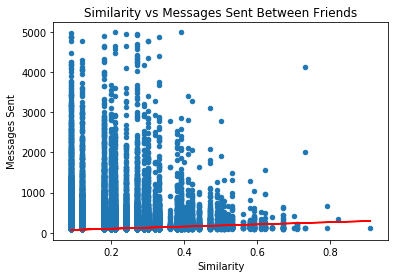

270.6693915924084


In [0]:
# f = pd.read_pickle(feat_folder+"friends_all_features.pkl")
f = add_similarity(f)
import numpy as np
temp = f[(f.similarity > 0) & (f.message_cnt > 100) & (f.message_cnt < 5000)]

temp.plot(kind="scatter", x="similarity",y="message_cnt")

plt.title('Similarity vs Messages Sent Between Friends')
plt.ylabel("Messages Sent")
plt.xlabel("Similarity")
b, m = np.polyfit(temp.similarity, temp.message_cnt, 1)
plt.plot(temp.similarity, b + m * temp.similarity, 'r')
plt.show()
print(m)

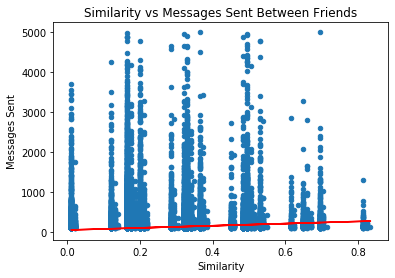

268.13341724244253


In [0]:
# f = pd.read_pickle(feat_folder+"friends_all_features.pkl")
# f = add_similarity(f)
import numpy as np
temp = f[(f.similarity > 0) & (f.message_cnt > 100) & (f.message_cnt < 5000)]

temp.plot(kind="scatter", x="similarity",y="message_cnt")

plt.title('Similarity vs Messages Sent Between Friends')
plt.ylabel("Messages Sent")
plt.xlabel("Similarity")
b, m = np.polyfit(temp.similarity, temp.message_cnt, 1)
plt.plot(temp.similarity, b + m * temp.similarity, 'r')
plt.show()
print(m)

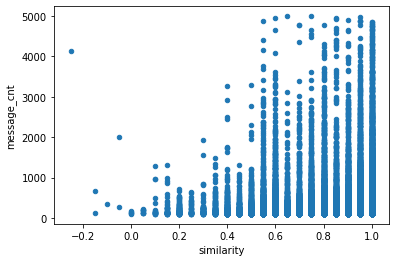

In [0]:
# f = add_similarity(f)
# fm = pd.read_pickle(feat_folder+"friends_table_clean_messages.pkl")
# f['message_cnt'] = fm.message_count


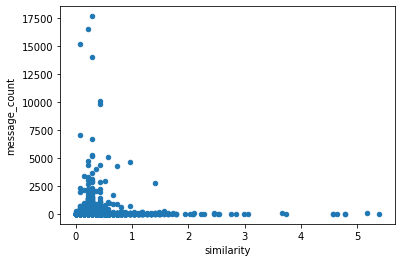

In [0]:
ds.plot(kind="scatter",y="message_count", x="similarity")

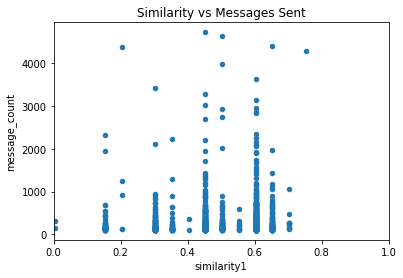

In [0]:
ds[(100 < ds.message_count) & (ds.message_count < 5000) ].plot(kind="scatter",y="message_count", x="similarity1")
plt.xlim(0,1)
plt.title("Similarity vs Messages Sent")
plt.ylabel("Mutual Message Count")
plt.xlabel("Calculated Frienship Similarity Score")
plt.show()

In [0]:
f = pd.read_pickle(clean_folder + "friends.pkl")
u = pd.read_pickle(clean_folder + "users.pkl")

In [0]:
fc = f.groupby("user_id")['friend_id'].apply(set)
# count().rename(columns={"friend_id":'friend_cnt'})
fc

user_id
001QkDMrFKORLwUgeGjJO7wXxnD2                       {gms0X5ymuzgvfb27mMPwWx99Nyu2}
0024bdecosW3PBRirMhwG5T0dPn2    {I47PDomZioXQUZE7etdidZnblRT2, WGWyDXmCv4TTtyo...
002FanjKr3dJA92FOEtdcrWJPLY2                       {TOki7uDgOWYnZtK8tAku9il9MbA2}
002GoCnNQ7PVFLXcMOYPFICzaJg1    {1Hh9rAwpDAUVmV3UpQ8MeepUmQ22, 6EMgKNQvb1V6n3j...
002xNbNRMmbO6wF7gR4prdj6rmD3    {NY14EyA0YcO2dLQ24RiK1nY9CgV2, jMUg8dhe7gUX9s2...
                                                      ...                        
zzvNpHfPMMTgH38gr6oTyX88oEh2    {SIVQqjBCVJUZfxMoAt0SetlCZUC2, K5fhsRRjYeeuOuN...
zzwmr5dwJuaYilIQGlJHAMhPB572                       {fVfLAefMCegQlMMUHxcdzACgYIm2}
zzx0NTpSicTD4acfqaB5k1HFhn33    {iqUH1Kohk2U3Bmtmcv7IEUzAp5q1, B63rnqi0e7WD2Gp...
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2    {xGWWc5YNNHWv9kuhNwIO8tdge2i1, xwjyVLbZvsf89q1...
zzzt4CujlpY8gbtIsrwAtBMxaGP2    {d0BobWZmmaeW4hMo2mVRS0mWAzH3, 7KTqXidVaSU7edM...
Name: friend_id, Length: 107819, dtype: object

In [0]:
f

,user_id,friend_id
0,VZgO20TG8VMpFfNOHnJ9obHtb3B3,5Yh7odIbJSOv1mQhF6zL6AYGSro2
1,iB1Ij0n52QfUJxsgMY2iBfUDE9I2,5Yh7odIbJSOv1mQhF6zL6AYGSro2
2,kOGGd219QIhbH1wZi1Tlkjn9seG2,5Yh7odIbJSOv1mQhF6zL6AYGSro2
3,YwGOuryXBFXJ1DONX7UjKFWnxfR2,5Zx0kUszLtMuTx6ENftlP49A9u22
4,AyKYguWUe6ZVi8DnaBUlgRaJOQh2,5egvOocg7KgOXYFEHRmAbUMlWQE2
...,...,...
1047309,BY6YaFOkD2fnDp1UQALgwzoykkq2,CphNNXdQHRhjow9RWImEQAT7odk2
1047310,xyWZDkTb1dbtrH2JZM0lA70iRYt2,ag9cHyNVGYakMg6FrHBCdHuUSfz2
1047311,3Se0PSjAftQKF9CFvnuNz0KACYj2,nqTTsyQk5wOGC3OA1ptGxCwcSQZ2
1047312,yLVtqNcLHtWIy7Zk9xBHDyDJ3s52,Xyzx859hQNWzPQSgy7gIuo2BILm2


In [0]:
u.merge(fc, how="left", left_index=True, right_index=True)

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt
user_id,,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0,NaN
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0,1.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0,11.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0,1.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,NaT,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0,3.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,NaT,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0,NaN
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,NaT,4,False,0.0,False,False,True,0.0,11.0


In [0]:
u = pd.read_pickle(feat_folder +"users.pkl")

In [0]:
(u.friend_cnt.value_counts().sort_index() - u.friend_cnt.value_counts().shift(-1).sort_index())[:50]

0.0     134175.0
1.0      15876.0
2.0       6014.0
3.0       2814.0
4.0       1679.0
5.0       1182.0
6.0        760.0
7.0        385.0
8.0        519.0
9.0        326.0
10.0       222.0
11.0       356.0
12.0        92.0
13.0        53.0
14.0       121.0
15.0       156.0
16.0        93.0
17.0        19.0
18.0        82.0
19.0        63.0
20.0        48.0
21.0        60.0
22.0         3.0
23.0        61.0
24.0        19.0
25.0         8.0
26.0        19.0
27.0        42.0
28.0        12.0
29.0        31.0
30.0         6.0
31.0        16.0
32.0        36.0
33.0        12.0
34.0         1.0
35.0        21.0
36.0         5.0
37.0         7.0
38.0         9.0
39.0         8.0
40.0         1.0
41.0         3.0
42.0         4.0
43.0         7.0
44.0         5.0
45.0         1.0
46.0        13.0
47.0        13.0
48.0         3.0
49.0         1.0
50.0         6.0
Name: friend_cnt, dtype: float64

In [0]:
u.friend_cnt.describe()

count    267367.000000
mean          3.694805
std          18.748055
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        4960.000000
Name: friend_cnt, dtype: float64

In [0]:
u[u.streamer == True]

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt
user_id,,,,,,,,,,,,,,,,,,,
1Z6XYA1vgQXiTQTRpNhzXsj42Qk1,0,United States of America,English,0.0,True,168,False,0,True,2019-11-04 01:20:42.801000+00:00,4,False,14.0,False,False,True,0.0,2.0,0.0
3nfoZZzaHEUJT1tcB2l7SjfLmuo2,0,United States of America,English,0.0,True,581,False,0,True,2019-11-01 01:45:30.184000+00:00,4,False,14.0,False,False,False,0.0,5.0,0.0
4snxVGwoygfE1bvjckKEJWMwk0B3,0,United States of America,English,0.0,True,2675,False,1300,True,2019-11-13 21:44:47.489000+00:00,4,False,17.0,True,False,False,0.0,12.0,1.0
5UFgehDCVkVTmfwTzBYLcCZKa0C3,2019-08-13 00:21:31.432000+00:00,Australia,English,0.0,True,1611,True,0,True,2019-11-10 14:58:18.159000+00:00,4,False,14.0,False,False,True,0.0,812.0,3.0
5avdDJJ0jGMgBTgrkt77Ied1BdA3,0,United States of America,English,0.0,True,1069,False,360,True,2019-11-13 03:06:59.300000+00:00,4,False,14.0,False,False,True,0.0,40.0,12.0
61bytXpS42csSHDt1Fkg6VpAYen2,2019-08-06 16:58:43.191000+00:00,United States of America,English,0.0,True,6889,False,1280,True,2019-11-13 07:13:05.997000+00:00,4,False,14.0,True,False,True,0.0,84.0,28.0
6TxFLRh4JmZxc4J63zKnWcxUqMC3,0,United States of America,English,0.0,True,168,False,0,False,2019-11-06 19:46:36.263000+00:00,4,False,14.0,False,False,False,0.0,0.0,0.0
6uUgP1pkdWXZr8O2UoD4MrcvgDS2,0,United States of America,English,0.0,True,414,False,0,False,2019-11-06 23:32:30.159000+00:00,4,False,14.0,False,False,False,0.0,0.0,0.0
6vNiqfr4wKT11SHZe8nQy4c0gGy2,0,United States of America,English,0.0,True,2535,False,50,True,2019-11-12 21:17:12.538000+00:00,4,False,23.0,False,False,False,0.0,21.0,2.0


In [0]:
users = pd.read_pickle(feat_folder+"users.pkl")

In [0]:
users.corr()

,points,streamer,follower_count,admin,coin_balance,bio,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt
points,1.000000,-0.000021,0.000648,-0.000026,-0.000010,-0.000623,0.004237,-0.000144,0.138587,0.035594,-0.000040,0.004674,1.000000,0.000135,0.008396
streamer,-0.000021,1.000000,0.665912,0.255047,0.296452,0.025749,0.023291,-0.000815,0.876781,0.037272,-0.000227,0.016762,-0.000021,0.137937,0.063145
follower_count,0.000648,0.665912,1.000000,0.264791,0.188085,0.021729,0.016238,-0.000552,0.614602,0.035690,-0.000154,0.012593,0.000648,0.331114,0.058723
admin,-0.000026,0.255047,0.264791,1.000000,0.233079,0.036795,0.012427,-0.000999,0.279958,0.050803,-0.000278,0.025271,-0.000026,0.166456,0.098182
coin_balance,-0.000010,0.296452,0.188085,0.233079,1.000000,0.013540,0.008144,0.003289,0.244310,0.039450,-0.000107,0.010794,-0.000010,0.079820,0.068316
bio,-0.000623,0.025749,0.021729,0.036795,0.013540,1.000000,0.103017,0.089355,0.025314,0.041130,0.026058,0.302266,-0.000623,0.191137,0.111182
english_proficiency,0.004237,0.023291,0.016238,0.012427,0.008144,0.103017,1.000000,0.072733,0.024971,0.008250,0.006350,0.094418,0.004237,0.063500,0.046828
banned,-0.000144,-0.000815,-0.000552,-0.000999,0.003289,0.089355,0.072733,1.000000,-0.000895,0.004334,0.098233,0.036001,-0.000144,0.118670,0.025932
hop_on_rate,0.138587,0.876781,0.614602,0.279958,0.244310,0.025314,0.024971,-0.000895,1.000000,0.039994,-0.000249,0.016114,0.138587,0.113604,0.055048
livestream_push_notify,0.035594,0.037272,0.035690,0.050803,0.039450,0.041130,0.008250,0.004334,0.039994,1.000000,-0.001127,0.108441,0.035594,0.058232,0.082061


In [0]:
friends = pd.read_pickle(feat_folder+"friends_all_features.pkl")

In [0]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267367 entries, 001GUmDfBjM1tx4alKHGTnYRUt62 to zzzt4CujlpY8gbtIsrwAtBMxaGP2
Data columns (total 19 columns):
last_status_update        267367 non-null object
native_country            267367 non-null object
native_lang               267367 non-null object
points                    267367 non-null float64
streamer                  267367 non-null bool
follower_count            267367 non-null int64
admin                     267367 non-null bool
coin_balance              267367 non-null int64
bio                       267367 non-null bool
last_online               267367 non-null object
english_proficiency       267367 non-null int64
banned                    267367 non-null bool
hop_on_rate               267367 non-null float64
livestream_push_notify    267367 non-null bool
suspended                 267367 non-null bool
push_notify               267367 non-null bool
level                     267367 non-null float64
friend_cnt                

In [0]:
users = users.merge(friends, left_index=True, on="user_id", how="left")

In [0]:
mes = users[users.message_cnt!=0]

In [0]:
mes.corr()

,points,streamer,follower_count,admin,coin_balance,bio,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt,same_native_language,same_native_country,english_proficiency_difference,common_friends,common_streamers,similarity,message_cnt
points,1.000000,-0.000165,-0.000109,-0.000201,-0.000146,-0.001378,0.003997,-0.000427,0.026723,0.017944,-0.000120,0.002950,1.000000,-0.000464,0.003186,0.003448,0.007613,-0.001937,0.003286,0.012124,0.002442,-0.000082
streamer,-0.000165,1.000000,0.904981,0.770559,0.765647,0.119586,0.141493,-0.015128,0.974123,0.067323,-0.004241,0.100888,-0.000165,0.805254,0.155919,0.014834,-0.009885,0.092400,0.130050,0.109127,0.106320,0.001494
follower_count,-0.000109,0.904981,1.000000,0.725241,0.863667,0.108497,0.128092,-0.013691,0.864644,0.028565,-0.003839,0.093458,-0.000109,0.937211,0.092714,0.017223,-0.009518,0.083242,0.107268,0.077086,0.095344,0.001747
admin,-0.000201,0.770559,0.725241,1.000000,0.690402,0.143865,0.116443,-0.018409,0.747713,0.111658,-0.005161,0.122261,-0.000201,0.685881,0.229683,0.002582,-0.011962,0.078213,0.170952,0.120924,0.094494,0.000792
coin_balance,-0.000146,0.765647,0.863667,0.690402,1.000000,0.104435,0.109830,-0.013117,0.729447,0.041721,-0.003750,0.089761,-0.000146,0.831442,0.110236,0.013512,-0.007120,0.068711,0.100632,0.107497,0.082042,0.001091
bio,-0.001378,0.119586,0.108497,0.143865,0.104435,1.000000,0.184539,0.089801,0.119028,0.079925,0.034780,0.339139,-0.001378,0.177222,0.169664,-0.008821,-0.022312,0.044563,0.082548,0.054628,0.053607,-0.001322
english_proficiency,0.003997,0.141493,0.128092,0.116443,0.109830,0.184539,1.000000,0.133884,0.139525,0.015416,-0.001837,0.142618,0.003997,0.149357,0.098257,0.063793,-0.039584,0.155360,0.094725,0.041693,0.180054,0.001332
banned,-0.000427,-0.015128,-0.013691,-0.018409,-0.013117,0.089801,0.133884,1.000000,-0.015125,-0.006251,0.081957,0.019157,-0.000427,0.030863,-0.006816,0.018910,-0.035013,0.029092,0.031526,-0.009543,0.039320,0.000517
hop_on_rate,0.026723,0.974123,0.864644,0.747713,0.729447,0.119028,0.139525,-0.015125,1.000000,0.067563,-0.004241,0.096843,0.026723,0.762190,0.150680,0.014575,-0.008582,0.091514,0.129543,0.108271,0.105714,0.001505
livestream_push_notify,0.017944,0.067323,0.028565,0.111658,0.041721,0.079925,0.015416,-0.006251,0.067563,1.000000,-0.006675,0.130202,0.017944,0.025016,0.180153,-0.002765,0.005867,0.000651,0.042211,0.068564,0.010108,-0.002434


In [0]:
user = users[users.streamer==False]
user = users[users.admin==False]

In [0]:
user.drop(columns=['streamer','admin']).corr()

,points,follower_count,coin_balance,bio,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt,same_native_language,same_native_country,english_proficiency_difference,common_friends,common_streamers,similarity,message_cnt
points,1.000000,0.000265,-0.000035,-0.001449,0.003847,-0.000449,0.067182,0.017271,-0.000128,0.002670,1.000000,-0.001150,0.003159,0.003985,0.006930,-0.001756,0.002960,0.012587,0.002738,-0.000004
follower_count,0.000265,1.000000,0.264711,0.023521,0.029609,-0.003458,0.687842,0.059948,-0.000981,0.014538,0.000265,0.001500,0.067820,0.005831,0.001355,0.016892,0.011481,0.055270,0.020994,-0.000406
coin_balance,-0.000035,0.264711,1.000000,0.017529,0.015943,-0.002909,0.343873,0.009971,-0.001000,0.011722,-0.000035,0.008894,0.080456,0.000167,0.000816,0.009310,0.013304,0.079545,0.011943,-0.000076
bio,-0.001449,0.023521,0.017529,1.000000,0.160838,0.078831,0.026839,0.062030,0.034881,0.296027,-0.001449,0.222422,0.135195,-0.009421,-0.021058,0.034053,0.071184,0.042873,0.040914,-0.000922
english_proficiency,0.003847,0.029609,0.015943,0.160838,1.000000,0.138209,0.035753,0.002070,-0.004374,0.117126,0.003847,0.101954,0.080569,0.061644,-0.037913,0.142628,0.090255,0.031133,0.166171,0.000643
banned,-0.000449,-0.003458,-0.002909,0.078831,0.138209,1.000000,-0.004181,-0.007884,0.084917,0.004521,-0.000449,0.126938,-0.011075,0.020400,-0.034074,0.029539,0.043264,-0.006378,0.041481,0.000538
hop_on_rate,0.067182,0.687842,0.343873,0.026839,0.035753,-0.004181,1.000000,0.022481,-0.001187,0.009684,0.067182,0.000827,0.041900,0.005698,0.002053,0.019875,0.014110,0.054103,0.024837,0.000242
livestream_push_notify,0.017271,0.059948,0.009971,0.062030,0.002070,-0.007884,0.022481,1.000000,-0.007383,0.118414,0.017271,0.038651,0.090623,0.001007,0.006102,-0.004901,0.011796,0.040566,0.002222,-0.001735
suspended,-0.000128,-0.000981,-0.001000,0.034881,-0.004374,0.084917,-0.001187,-0.007383,1.000000,0.011397,-0.000128,0.020299,-0.004035,-0.008682,-0.007766,0.002654,0.002060,-0.002271,-0.002066,-0.000199
push_notify,0.002670,0.014538,0.011722,0.296027,0.117126,0.004521,0.009684,0.118414,0.011397,1.000000,0.002670,0.218441,0.094603,-0.006801,-0.008663,0.021284,0.055609,0.015357,0.027387,-0.000879


In [0]:
users = pd.read_pickle(feat_folder+"users.pkl")

In [0]:
users

,last_status_update,native_country,native_lang,points,streamer,follower_count,admin,coin_balance,bio,last_online,english_proficiency,banned,hop_on_rate,livestream_push_notify,suspended,push_notify,level,friend_cnt,followed_cnt
user_id,,,,,,,,,,,,,,,,,,,
001GUmDfBjM1tx4alKHGTnYRUt62,2019-07-28 12:30:51.844000+00:00,India,Hindi,0.0,False,0,False,0,False,2019-07-28 12:30:51.844000+00:00,2,False,0.0,False,False,False,0.0,0.0,0.0
001QkDMrFKORLwUgeGjJO7wXxnD2,2019-07-31 02:18:36.962000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,2019-07-31 02:18:36.962000+00:00,2,False,0.0,False,False,False,0.0,1.0,0.0
0024bdecosW3PBRirMhwG5T0dPn2,2019-06-11 15:52:35.621000+00:00,Spain,Spanish,0.0,False,0,False,0,False,2019-06-11 15:52:35.621000+00:00,1,False,0.0,False,False,True,0.0,11.0,0.0
002FanjKr3dJA92FOEtdcrWJPLY2,2019-07-02 10:31:59.306000+00:00,Australia,Albanian,0.0,False,0,False,0,False,2019-07-02 10:31:59.306000+00:00,2,False,0.0,False,False,True,0.0,1.0,0.0
002GoCnNQ7PVFLXcMOYPFICzaJg1,2019-09-19 11:10:14.762000+00:00,Egypt,Arabic,0.0,False,0,False,0,False,2019-10-19 00:30:52.627000+00:00,2,False,0.0,False,False,True,0.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzx0NTpSicTD4acfqaB5k1HFhn33,0,Indonesia,Indonesian,0.0,False,0,False,0,False,2019-08-20 17:35:45.400000+00:00,1,False,0.0,False,False,False,0.0,3.0,0.0
zzx6deTfKhhAbAgD6cWp5XlnFwH2,0,Jordan,Afar,0.0,False,0,False,0,False,2019-09-29 08:53:49.353000+00:00,3,False,0.0,False,False,False,0.0,0.0,0.0
zzzOh6WfLjQ2vacJ0yMj4bP6oZp2,2019-10-05 15:20:40.699000+00:00,Brazil,Portuguese,0.0,False,0,False,0,False,0,4,False,0.0,False,False,True,0.0,11.0,0.0


In [0]:
friends = pd.read_pickle(feat_folder+"friends_all_features.pkl")

In [0]:
friends

,user_id,friend_id,same_native_language,same_native_country,english_proficiency_difference,common_friends,common_streamers,similarity,message_cnt
0,VZgO20TG8VMpFfNOHnJ9obHtb3B3,5Yh7odIbJSOv1mQhF6zL6AYGSro2,0,0,0,0,0,0.00,0.0
1,iB1Ij0n52QfUJxsgMY2iBfUDE9I2,5Yh7odIbJSOv1mQhF6zL6AYGSro2,1,0,1,1,0,0.35,0.0
2,kOGGd219QIhbH1wZi1Tlkjn9seG2,5Yh7odIbJSOv1mQhF6zL6AYGSro2,1,0,0,0,0,0.20,0.0
3,copjsSmj3aZyUfoGpv9TMfQ5Zsq1,5Yh7odIbJSOv1mQhF6zL6AYGSro2,0,0,0,6,0,0.10,0.0
4,6QdbOrNpdzSLSqapMDwgFl7p7Pq2,5Yh7odIbJSOv1mQhF6zL6AYGSro2,0,0,3,1,0,0.45,0.0
...,...,...,...,...,...,...,...,...,...
967877,sHieerZdfbgUzSwYeWH2fmQ3NL42,JBWkJ6IT5LXMXqwsOl3rLUfIf452,0,0,0,0,0,0.00,0.0
967878,mzkuGuvwXPUgW4etStYek3cXzG52,vNLWcDkZoihK0XglzUtwzamTcpI2,1,1,1,0,0,0.40,0.0
967879,cOnlN1ZUQLdEAhEDDHjpdsy9MPr1,v1MPOvLbmihjsHpq3LulK4WJNm62,1,0,2,0,0,0.50,0.0
967880,qeQd0QR8EodyCjbftIoBXAx07Nj2,g7Np2hg5seOeE3PA87ZoUFkU60A2,0,0,0,0,0,0.00,0.0
